In [1]:
import binascii
import glob
import itertools
import os
import os.path
import random
import time

from collections import defaultdict
from functools import reduce

In [2]:
corpus_folder = "./data/enrontest/"
corpus_test_folder = "./data/test"
test_file_path = "./data/test/1.txt"

In [3]:
def file_to_shingles(file_path, shingle_size=2, do_hash=True):
    with open(file_path, 'r') as infile:
        content = infile.read()
        shingles = set()
        for i in range(len(content) - shingle_size):
            shingle = content[i:i+shingle_size]
            shingles.add(
                hash_shingle(shingle) if do_hash else shingle
            )
        return sorted(list(shingles))

def hash_shingle(shingle):
    """Hashes a shingle to a 32bit integer.
    
    """
    return binascii.crc32(shingle.encode("utf-8")) & 0xffffffff

################
##### TEST #####
################
shingle_size = 2
print("Shingles in {} (<raw> --> <hashed>)".format(test_file_path))
shingles_raw = file_to_shingles(test_file_path, shingle_size=shingle_size, do_hash=False)
shingles_hashed = file_to_shingles(test_file_path, shingle_size=shingle_size, do_hash=True)
for shingle, shingle_hashed in zip(shingles_raw, shingles_hashed):
    print("{} --> {}".format(shingle, shingle_hashed))

if len(file_to_shingles(test_file_path)) != len(file_to_shingles(test_file_path, do_hash=False)):
    print("Hey, we have a problem!")

Shingles in ./data/test/1.txt (<raw> --> <hashed>)
 c --> 15075007
 m --> 105998545
 s --> 156340709
a  --> 238835196
ai --> 312708591
am --> 491853531
ao --> 809500611
ci --> 996668263
co --> 1648209365
e  --> 2428467314
ia --> 2563917151
ma --> 2726894320
me --> 2873054939
mm --> 2891092674
o  --> 3478361055
om --> 3523499602
st --> 3761386704
ta --> 3881708472


In [4]:
def jacard_similarity(set_1, set_2):
    return len(set_1.intersection(set_2)) / len(set_1.union(set_2))

################
##### TEST #####
################
set_1 = {"a", "b", "c"}
set_2 = {"b", "c", "d"} 
print("Jaccard similarity between {} and {} = {}".format(
    set_1, set_2, jacard_similarity(set_1, set_2)))

Jaccard similarity between {'c', 'b', 'a'} and {'c', 'd', 'b'} = 0.5


In [5]:
class HashStore:
    # next prime of 2^32 - 1 is 4294967311
    # http://compoasso.free.fr/primelistweb/page/prime/liste_online_en.php
    max_shingle_hash = 2**32 - 1
    next_prime = 4294967311
    
    def __init__(self, number_of_hash_functions=100, seed=None):
        if seed:
            random.seed(seed)
        self.n_hash_functions = number_of_hash_functions  # the length of the signature
        self.a_coefficients = self.generate_coefficient_list(number_of_hash_functions)
        self.b_coefficients = self.generate_coefficient_list(number_of_hash_functions)
    
    def generate_coefficient_list(self, number_of_coefficients):
        # integers in python have arbitrary precision (not applicable to numpy)
        # https://mortada.net/can-integer-operations-overflow-in-python.html
        coefficients = []
        
        def random_int():
            return random.randint(1, self.max_shingle_hash)
        
        for _ in range(number_of_coefficients):
            candidate = random_int()
            while candidate in coefficients:
                candidate = random_int()
            coefficients.append(candidate)
        
        return coefficients
    
    def hash_function(self, function_index, value):
        assert function_index < self.n_hash_functions, "Function index out of range"
        assert type(value) == int, "Cannot hash strings, yet..."
        a = self.a_coefficients[function_index]
        b = self.b_coefficients[function_index]
        return (a * value + b) % self.next_prime & 0xffffffff  # not really needed it
    
    def get_signature(self, set_of_shingles):
        signature = []  # needs to keep the order of insertion, the set will not grant it
        for i in range(self.n_hash_functions):
            signature.append(
                min(map(lambda x: self.hash_function(i,x) ,set_of_shingles))
            )
        return signature
    
            
################
##### TEST #####
################
n_hash_functions = 8
hash_store = HashStore(n_hash_functions, seed=42)
shingles_set = file_to_shingles(test_file_path)
set_signature = hash_store.get_signature(shingles_set)
print("Signature of document {} (using {} hash functions)".format(test_file_path, n_hash_functions))
print(hash_store.get_signature(shingles_set))

Signature of document ./data/test/1.txt (using 8 hash functions)
[52407992, 301237324, 671516145, 569331182, 1716025017, 120599866, 240546662, 161921516]


In [6]:
def compare_signatures(sign1, sign2):
    assert len(sign1) == len(sign2)
    # this is one liner in numpy, but we decided to use only plain python
    # also with numpy we must pay attention to not overflow when calculating
    # the hashes
    return sum([x == y for x,y in zip(sign1, sign2)]) / len(sign1)

def find_similar_sets(collection_sets, threshold, similarity_fn):
    similar_docs = set()
    for (i, sign1), (j, sign2) in itertools.combinations(enumerate(collection_sets), 2):
        similarity = similarity_fn(sign1, sign2)
        if similarity >= threshold:
            similar_docs.add((i, j, similarity))
    return similar_docs

################
##### TEST #####
################
n_hash_functions = 8
hash_store = HashStore(n_hash_functions, seed=42)
file_list = glob.glob(os.path.join(corpus_test_folder, "*"))
shingle_sets = list(map(file_to_shingles, file_list))
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
print("Using {} hash functions!".format(n_hash_functions))
print("Processed files:")
print(file_list)
print("Signature matrix ({} x {}):".format(len(signature_matrix), len(signature_matrix[0])))
print('\n'.join([' '.join(['{:10}'.format(item) for item in row]) 
      for row in signature_matrix]))
for (i, sign1), (j, sign2) in itertools.combinations(enumerate(signature_matrix), 2):
    print("Similarity between {} and {} = {}".format(file_list[i], file_list[j], 
                                                     compare_signatures(sign1,sign2)))

Using 8 hash functions!
Processed files:
['./data/test/1.txt', './data/test/3.txt', './data/test/2.txt']
Signature matrix (3 x 8):
  52407992  301237324  671516145  569331182 1716025017  120599866  240546662  161921516
  52407992  301237324  104680079  569331182  230774069  120599866   75362837  161921516
 518549885  138899815  185659784  301924761   93036249   27538086  240546662  378500321
Similarity between ./data/test/1.txt and ./data/test/3.txt = 0.625
Similarity between ./data/test/1.txt and ./data/test/2.txt = 0.125
Similarity between ./data/test/3.txt and ./data/test/2.txt = 0.0


In [7]:
class LSH:
    def __init__(self, signature_matrix, bands, threshold = 0.5):
        # using only bands because the bands * rows = len(signature)
        self.signature_matrix = signature_matrix
        self.bands = bands
        # the last band, if not completed, is hashed anyway
        self.signature_length = len(self.signature_matrix[0])
        
        assert self.signature_length >= self.bands
        self.rows = self.signature_length // self.bands
        
        self.threshold = threshold
    
    def hash_band_item(self, band):
        return reduce(lambda x,y : "{}{}".format(x,y), band)
        
    def get_band_item(self, band_index, doc_index):
        start_index = band_index * self.rows
        end_index = min((band_index + 1) * self.rows, self.signature_length)
        assert start_index < end_index
        return self.signature_matrix[doc_index][start_index : end_index]
    
    def get_band_candidates(self, band_index):
        hash_table = defaultdict(list)
        for doc_index in range(len(self.signature_matrix)) :
            band_item = self.get_band_item(band_index, doc_index)
            hash_table[self.hash_band_item(band_item)].append(doc_index)
        
        candidates = []
        for values in hash_table.values():
            if len(values) > 1:
                candidates += list(itertools.combinations(sorted(values), 2))  # get the list of candidate PAIRS
        return set(candidates)  # unique pairs
    
    def get_candidates(self):
        candidates = set()
        for i in range(self.bands):
            candidates = candidates.union(self.get_band_candidates(i))
        return candidates
    
    def get_similar(self):
        similar_docs = set()
        candidates = self.get_candidates()
        for doc_index_1, doc_index_2 in candidates:
            sign1, sign2 = signature_matrix[doc_index_1], signature_matrix[doc_index_2]
            similarity = compare_signatures(sign1, sign2)
            if similarity >= self.threshold:
                similar_docs.add((doc_index_1,doc_index_2,similarity))
        return similar_docs

In [8]:
################
## REAL TEST ###
################

def print_ranking(results, time):
    print("***** RANKING ({:d} pairs retrieved in {:d}ms) *****".format(len(results), time))
    for doc1_idx, doc2_idx, similarity in results:
        doc1 = file_list[doc1_idx]
        doc2 = file_list[doc2_idx]
        print("Similarity: {:4}".format(similarity))
        print("{} and {}".format(doc1, doc2))
        print("*****")
        
def millis():
    return int(round(time.time() * 1000))

#### CONFIG ####
n_hash_functions = 100
bands = 25  # lower or equal to the number of hash functions!
threshold = 0.3
################
rows = n_hash_functions // bands

file_list = glob.glob(os.path.join(corpus_folder, "*"))
print("Configuration:")
print(" - Number of files:", len(file_list))
print(" - Number of hash functions:", n_hash_functions)
print(" - Number of bands:", bands)
print(" - Number of rows per band (inferred):", rows)
print(" - LSH similarity threshold 't':", threshold)

tick = millis()
shingle_sets = list(map(file_to_shingles, file_list))
hash_store = HashStore(n_hash_functions, seed=42)
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
tock = millis()
time_minhashing = (tock - tick)
print("\nMinhashing time: {}ms".format(time_minhashing))
print("Signature matrix shape: {} x {}".format(len(signature_matrix), 
                                               len(signature_matrix[0])))

print("\n***** LSH *****")
tick = millis()
lsh = LSH(signature_matrix, bands, threshold)
similar_pairs = lsh.get_similar()
tock = millis()
time_lsh = (tock - tick)

similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs, time_lsh)

# Compare it to the time to compute all the similarities
print("\n***** ALL *****")
tick = millis()
similar_pairs_all = find_similar_sets(signature_matrix, threshold, similarity_fn=compare_signatures)
tock = millis()
time_all = (tock - tick)        

similar_pairs_all = sorted(similar_pairs_all, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs_all, time_all)

Configuration:
 - Number of files: 5
 - Number of hash functions: 100
 - Number of bands: 25
 - Number of rows per band (inferred): 4
 - LSH similarity threshold 't': 0.3

Minhashing time: 135ms
Signature matrix shape: 5 x 100

***** LSH *****
***** RANKING (7 pairs retrieved in 1ms) *****
Similarity: 0.46
./data/enrontest/0065.2003-12-23.GP.spam.txt and ./data/enrontest/0069.2003-12-23.GP.spam.txt
*****
Similarity: 0.44
./data/enrontest/0062.2003-12-22.GP.spam.txt and ./data/enrontest/0058.2003-12-21.GP.spam.txt
*****
Similarity: 0.43
./data/enrontest/0065.2003-12-23.GP.spam.txt and ./data/enrontest/0062.2003-12-22.GP.spam.txt
*****
Similarity: 0.42
./data/enrontest/0061.2003-12-21.GP.spam.txt and ./data/enrontest/0058.2003-12-21.GP.spam.txt
*****
Similarity: 0.41
./data/enrontest/0069.2003-12-23.GP.spam.txt and ./data/enrontest/0058.2003-12-21.GP.spam.txt
*****
Similarity:  0.4
./data/enrontest/0069.2003-12-23.GP.spam.txt and ./data/enrontest/0062.2003-12-22.GP.spam.txt
*****
Similar

In [9]:
# LET'S HAVE SOME FUN (SORRY GIO)

#### CONFIG ####
n_hash_functions = 100
bands = 23  # lower or equal to the number of hash functions!
threshold = 0.4
################

# https://en.wikipedia.org/wiki/Precision_and_recall
# We are going to:
# 1. Get similar pairs of documents using Jaccard similarity (via shingles)
#    This will be our "ground truth"
# 2. Get similar pairs of documents using LSH (via signature matrix)
#    This will be our "selected positives examples (some of the migh be FP)"
# 3. Compute precision and recall.

# 1.Get similar pairs of documents using Jaccard similarity (via shingles)
file_list = glob.glob(os.path.join(corpus_folder, "*"))
shingle_sets = map(file_to_shingles, file_list)
# Convert to set (we had to use list to preserve order)
shingle_sets = [set(shingles) for shingles in shingle_sets]
relevant_elements = find_similar_sets(shingle_sets, threshold, jacard_similarity)
# Remove similarity. Just keep the pair of indexes
relevant_elements = {(x[0], x[1]) for x in relevant_elements}
# Find how many document pairs exist ((n * (n - 1)) / 2)
n = len(file_list)
number_possible_pairs = (n * (n - 1)) // 2
print("Relevant (similar) sets using Jaccard similarity (threshold = {}):".format(threshold))
print(set(relevant_elements))
print("Total combinations: {}. Relevant: {}. Nonrelevant: {}".format(
    number_possible_pairs, len(relevant_elements), number_possible_pairs - len(relevant_elements)))

# 2. Get similar pairs of documents using LSH (via signature matrix)
hash_store = HashStore(n_hash_functions, seed=42)
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
lsh = LSH(signature_matrix, bands, threshold)
selected_positives = lsh.get_similar()
# Remove similarity. Just keep the pair of indexes
selected_positives = {(x[0], x[1]) for x in selected_positives}
print("Relevant (similar) sets using LSH (threshold = {}):".format(threshold))
print(selected_positives)

# 3. Compute precision and recall.
def confusion_matrix(relevant_elements, selected_positives, number_possible_pairs):
    tp = 0
    fp = 0
    for pair in selected_positives:
        if pair in relevant_elements:
            tp += 1
        else:
            fp += 1
    # False negatives are the remaining pairs that we haven't checked
    fn = len(relevant_elements - selected_positives)
    # True negatives are the remaining sets
    tn = number_possible_pairs - (tp + fp + fn)
    if tp == 0:
        prec = rec = 0
    else:
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
    return {"tp": tp, "fp": fp, "tn": tn, "fn": fn, 
            "prec": prec, "rec": rec}

def print_confusion_matrix(cm):
    print("\n***** Confusion Matrix *****")
    print("True positives:  {:d}".format(cm["tp"]))
    print("True negatives:  {:d}".format(cm["tn"]))
    print("False positives: {:d}".format(cm["fp"]))
    print("False negatives: {:d}".format(cm["fn"]))
    print("**********")
    print("Precision: {:.3f}".format(cm["prec"]))
    print("Recall:    {:.3f}".format(cm["rec"]))
    print("****************************")

cm = confusion_matrix(relevant_elements, selected_positives, number_possible_pairs)
print_confusion_matrix(cm)

Relevant (similar) sets using Jaccard similarity (threshold = 0.4):
{(0, 1), (1, 3), (1, 4), (2, 3), (0, 4), (0, 3), (3, 4), (2, 4)}
Total combinations: 10. Relevant: 8. Nonrelevant: 2
Relevant (similar) sets using LSH (threshold = 0.4):
{(1, 2), (1, 4), (2, 4), (3, 4), (0, 2)}

***** Confusion Matrix *****
True positives:  3
True negatives:  0
False positives: 2
False negatives: 5
**********
Precision: 0.600
Recall:    0.375
****************************


In [10]:
# Super mega hyper fun part (but run the code above first!)
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

results = defaultdict(list)

#### CONFIG ####
threshold = 0.2
band_values_to_try = 20
################
band_values = np.linspace(1, n_hash_functions, band_values_to_try, dtype=int)

for bands in tqdm_notebook(band_values):
    lsh = LSH(signature_matrix, bands, threshold)
    selected_positives = lsh.get_similar()
    # Remove similarity. Just keep the pair of indexes
    selected_positives = {(x[0], x[1]) for x in selected_positives}
    cm = confusion_matrix(relevant_elements, selected_positives, number_possible_pairs)
    for key, value in cm.items():
        results[key].append(value)
    results["bands"].append(bands)
    results["threshold"].append(threshold)
    
df_results = pd.DataFrame(results)

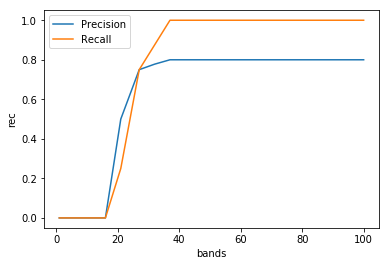

In [11]:
ax = sns.lineplot(x="bands", y="prec", markers=True, label="Precision", data=df_results)
ax = sns.lineplot(x="bands", y="rec", markers=True, label="Recall", data=df_results, ax=ax)

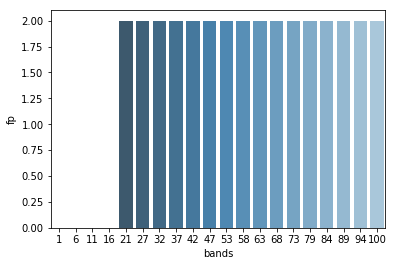

In [12]:
sns.barplot(x="bands", y="fp", data=df_results, palette="Blues_d")